In [7]:
cd Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src

Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
from neurochat.nc_data import NData
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
import neurochat.nc_plot as nc_plot
from neurochat.nc_lfp import NLfp
import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
import math
import pynapple as nap
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
import os
os.chdir(r"Q:\sachuriga\Sachuriga_Python\quattrocolo-nwb4fp\src")
import sys
import nwb4fp.analyses.maps as mapp
from nwb4fp.analyses.examples.tracking_plot import plot_ratemap,plot_path,plot_ratemap_ax
from nwb4fp.analyses.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from nwb4fp.analyses import maps
from nwb4fp.analyses.data import pos2speed,speed_filtered_spikes,load_speed_fromNWB,load_units_fromNWB,find_run_indices
from nwb4fp.data.helpers import unit_location_ch
from scipy.ndimage import gaussian_filter
from nwb4fp.preprocess.down_sample_lfp import down_sample_lfp_test
import ast
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import os
import pandas as pd

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
file_path = r"Q:\sachuriga\Sachuriga_Python/quattrocolo-nwb4fp/ASSY-236-F.prb"
# Read the file and parse the dictionary
local_vars = {'np': np}
with open(file_path, 'r') as file:
    exec(file.read(), local_vars)  # Execute the file content with NumPy in scope

channel_groups = local_vars.get('channel_groups')
if channel_groups is None:
    raise ValueError(f"'channel_groups' not found in {file_path}")

# Assuming channel_groups is loaded from Step 1
data = []
for group_id, group_data in channel_groups.items():
    channels = group_data['channels']
    geometry = group_data['geometry']
    for channel in channels:
        x, y = geometry[channel]
        data.append({
            'group_id': group_id,
            'channel_id': channel,
            'x': x,
            'y': y
        })
probe_df = pd.DataFrame(data)

# 你的数据和 DataFrame
data = probe_df  # 我省略了完整数据，因为它已经在上文给出

# 分组函数
def group_channels_by_group(df, channels):
    grouped = {}
    for channel in channels:
        group = df[df['channel_id'] == channel]['group_id'].values[0]
        if group not in grouped:
            grouped[group] = []
        grouped[group].append(channel)
    return grouped

# 找到每个组的中间 channel_id
def find_middle_channel_per_group(df, grouped_channels):
    middle_channels = {}
    for group, channels in grouped_channels.items():
        group_df = df[df['channel_id'].isin(channels)]
        sorted_df = group_df.sort_values('y', ascending=False).reset_index(drop=True)
        middle_idx = len(sorted_df) // 2
        middle_channel = sorted_df.iloc[middle_idx]['channel_id']
        middle_channels[group] = middle_channel
    return middle_channels

# 映射中间 channel 到输入列表
def map_middle_channels_to_input(df, channel_list, middle_channels):
    output_list = []
    for channel in channel_list:
        group = df[df['channel_id'] == channel]['group_id'].values[0]
        output_list.append(middle_channels[group])
    return output_list

# 找到每个组中间 channel 的下第 4 个
def find_lower_four_channel_per_group(df, grouped_channels, middle_channels):
    lower_four_dict = {}
    for group, middle_channel in middle_channels.items():
        group_df = probe_df[probe_df['group_id'] == group][['channel_id', 'y']]
        sorted_group = group_df.sort_values('y', ascending=False).reset_index(drop=True)
        start_idx = sorted_group[sorted_group['channel_id'] == middle_channel].index[0]
        target_idx = start_idx + 4
        if target_idx < len(sorted_group):
            lower_four_dict[group] = sorted_group.iloc[target_idx]['channel_id']
        else:
            lower_four_dict[group] = np.nan
    return lower_four_dict

# 映射下第 4 个到输入列表
def map_lower_four_to_input(df, channel_list, lower_four_dict):
    lower_four_output_list = []
    for channel in channel_list:
        group = df[df['channel_id'] == channel]['group_id'].values[0]
        lower_four_output_list.append(lower_four_dict[group])
    return lower_four_output_list
# Function to get pickle files
def get_pkl_files(folder_path):
    all_files = os.listdir(folder_path)
    pkl_files = [f for f in all_files if f.endswith("withDLC.pkl")]
    return pkl_files

# Define group prefixes
target_prefixes_control = ['65165', '65091', '63383', '66539', '65622']
target_prefixes_exp = ['65588', '63385', '66538', '66537', '66922']


In [ ]:
### Collecting LFPs
base_folder = r"S:\Sachuriga\Ephys_Recording\CR_CA1/"
pkl_files = get_pkl_files(r"S:\Sachuriga\file_with_table\ripple_ch/")
pkl_fodler = r"S:\Sachuriga\file_with_table\ripple_ch/"
phy_folder = r"S:\Sachuriga\Ephys_Recording\CR_CA1/"
all_dataframes = []
error_log=[]


for file in pkl_files:
    
    #file=r'66922_2024-09-25_15-39-48_units_table_withDLC.pkl'
    #try:
        #file = '66922_2024-09-25_15-39-48_units_table_withDLC.pkl'
        # Read and process the pickle file
        #df_files = pd.read_pickle(fr"{base_folder}{file}")
    unit_table = pd.read_pickle(fr"{pkl_fodler}/{file}")
    pyramidal_df = unit_table[unit_table['cell_type']=="pyramidal"]
    
    # Check if pyramidal_df is empty
    if pyramidal_df.empty:
        print(f"No pyramidal cells found in {file}")
        continue
    
    file_path_nwb = pyramidal_df['session_id'].iloc[0]
    channel_list = pyramidal_df['ripple_ch_3std'].values

    # Channel grouping and calculations
    grouped_channels = group_channels_by_group(probe_df, channel_list)
    middle_channels = find_middle_channel_per_group(probe_df, grouped_channels)
    output_list = map_middle_channels_to_input(probe_df, channel_list, middle_channels)
    lower_four_dict = find_lower_four_channel_per_group(probe_df, grouped_channels, middle_channels)
    lower_four_output_list = map_lower_four_to_input(probe_df, channel_list, lower_four_dict)

    # Print results
    print(f"\nProcessing file: {file}")
    print("Grouped channels:", grouped_channels)
    print("Middle channel per group:", middle_channels)
    print("Output list (length 10):", output_list)
    print("Lower four dict (by group):", lower_four_dict)
    print("Lower four output list:", lower_four_output_list)

    # Channel selection
    chs_py = np.int64(list(middle_channels.values()))
    chs_sr = np.int64([num for num in lower_four_dict.values() if not np.isnan(num)])


    phy_file = unit_table['session_id'].iloc[0].split(".nwb")[0]
    animals_id = unit_table['session_id'].iloc[0].split("_")[0]
    try:
        bad_channels = np.load(rf"{phy_folder}/{animals_id}/{phy_file}/bad_channels.npy")
    except Exception as e:
        bad_channels = []

    chs_py = [x for x in chs_py if x not in bad_channels]
    chs_sr = [x for x in chs_sr if x not in bad_channels]

    if not chs_py and not chs_sr:
        continue

    os_fodler = unit_table['session_id'].iloc[0].split("_phy_k_manual.nwb")[0]
    temp_folder = r"C:/temp_lfp"
    animal_id = pyramidal_df['animal_id'].iloc[0]
    session_id = pyramidal_df['session_id'].iloc[0]
    day = pyramidal_df['matlab_day'].iloc[0]
    path = fr"{base_folder }/{animal_id}/{phy_file}/"
    raw_path = fr"{base_folder}/{animal_id}/{os_fodler}/"
    # Load NWB file
    filepath = rf"S:\Sachuriga\nwb\test4neo/{file_path_nwb}"
    npdata = nap.load_file(filepath)
    #down_sample_lfp_test(path,raw_path)

    # Extract data
    eeg_raw = np.load(rf"{phy_folder}/{animals_id}/{phy_file}/lfp_zscore.npy")
    lfp_times = np.load(rf"{phy_folder}/{animals_id}/{phy_file}/lfp_times.npy")
    eeg = nap.TsdFrame(t=lfp_times, d=eeg_raw, time_units='s')
    
    forward_ep = npdata['Mid_brain_cords']
    
    if  forward_ep.index.values[-1] >lfp_times[-1]:
        forward_ep = forward_ep[forward_ep.index.values<lfp_times[-1],:]

    RUN_interval = nap.IntervalSet(forward_ep.start, forward_ep.end)
    
    # Position and speed processing
    pos_cord = load_speed_fromNWB(forward_ep)
    raw_pos, combined_array, mask, speeds, smoothed_speed, filtered_speed = pos2speed(
        pos_cord[:,0], pos_cord[:,1], pos_cord[:,2],
        filter_speed=True, min_speed=0.05
    )
    time_stemp = pos_cord[:,0]

    # Initialize lists for this iteration
    lfp_py = []
    lfp_sr = []
    lfp_py_time = []
    lfp_sr_time = []
    
    # Get identifiers
    # Process pyramidal channels
    if any(chs_py):
        for ch_num in chs_py:
            eeg_example = eeg.restrict(RUN_interval)[:, ch_num]
            fs = 1250
            t = eeg_example.t
            lfp_data = eeg_example.d

            # Bandpass filter
            lowcut = 4
            highcut = 125
            nyquist = fs / 2
            order = 4
            from scipy import signal
            b, a = signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
            bandpassed_data = signal.filtfilt(b, a, lfp_data)
            eeg_example = nap.Tsd(t=t, d=bandpassed_data)

            lfp_py_time.append(t)
            lfp_py.append(eeg_example)

    # Process SR channels
    if any(chs_sr):
        for ch_num in chs_sr:
            eeg_example = eeg.restrict(RUN_interval)[:, ch_num]
            fs = 1250
            t = eeg_example.t
            lfp_data = eeg_example.d

            # Bandpass filter
            lowcut = 4
            highcut = 125
            nyquist = fs / 2
            order = 4
            from scipy import signal
            b, a = signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
            bandpassed_data = signal.filtfilt(b, a, lfp_data)
            eeg_example = nap.Tsd(t=t, d=bandpassed_data)

            lfp_sr_time.append(t)
            lfp_sr.append(eeg_example)

    # Create DataFrame for this iteration
    iteration_df = pd.DataFrame({
        'animal_id': [animal_id],
        'session_id': [session_id],
        'matlab_day': [day],
        'lfp_py': [lfp_py],
        'lfp_sr': [lfp_sr],
        'lfp_py_time': [lfp_py_time],
        'lfp_sr_time': [lfp_sr_time],
        'smoothed_speed': [smoothed_speed],
        'time_stemp': [time_stemp],
        'file_path': [file]  # Adding source file info
    })
    
    # Append to list of DataFrames
    all_dataframes.append(iteration_df)
    # except Exception as e:
    #     error_log.append((file,e))

# Combine all DataFrames into one
final_df = pd.concat(all_dataframes, ignore_index=True)

# Optional: Save to file
final_df.to_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/combined_data_for_LFP.pkl')

print(f"\nProcessed {len(all_dataframes)} files")
print(f"Final DataFrame shape: {final_df.shape}")
print("Columns:", final_df.columns.tolist())


Processing file: 63383_2024-07-10_15-37-51_units_table_withDLC.pkl
Grouped channels: {0: [3, 3, 3], 1: [6, 6, 6], 2: [28, 28], 3: [53, 53, 53, 53, 53, 53, 53], 4: [49, 49, 49, 49, 49, 49], 5: [55, 55]}
Middle channel per group: {0: 3.0, 1: 6.0, 2: 28.0, 3: 53.0, 4: 49.0, 5: 55.0}
Output list (length 10): [3.0, 3.0, 3.0, 6.0, 6.0, 6.0, 28.0, 28.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 55.0, 55.0]
Lower four dict (by group): {0: 8.0, 1: 30.0, 2: 7.0, 3: 50.0, 4: nan, 5: nan}
Lower four output list: [8.0, 8.0, 8.0, 30.0, 30.0, 30.0, 7.0, 7.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, nan, nan, nan, nan, nan, nan, nan, nan]

Processing file: 63383_2024-07-13_14-10-05_units_table_withDLC.pkl
Grouped channels: {4: [37, 37, 37, 37], 5: [38, 38, 38, 38], 2: [27], 3: [58]}
Middle channel per group: {4: 37.0, 5: 38.0, 2: 27.0, 3: 58.0}
Output list (length 10): [37.0, 37.0, 37.0, 37.0, 38.0, 38.0, 38.0, 38.0, 27.0, 58.0]
Lower four dict (by group): {4: 44.

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 63383_2024-07-15_15-18-02_units_table_withDLC.pkl
Grouped channels: {5: [62, 62], 4: [41]}
Middle channel per group: {5: 62.0, 4: 41.0}
Output list (length 10): [62.0, 62.0, 41.0]
Lower four dict (by group): {5: nan, 4: 37.0}
Lower four output list: [nan, nan, 37.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 63383_2024-07-15_15-44-58_units_table_withDLC.pkl
Grouped channels: {5: [35, 35]}
Middle channel per group: {5: 35.0}
Output list (length 10): [35.0, 35.0]
Lower four dict (by group): {5: 55.0}
Lower four output list: [55.0, 55.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 63383_2024-07-18_14-13-10_units_table_withDLC.pkl
Grouped channels: {2: [7, 7, 7], 0: [4, 4], 1: [9]}
Middle channel per group: {2: 7.0, 0: 4.0, 1: 9.0}
Output list (length 10): [7.0, 7.0, 7.0, 4.0, 4.0, 9.0]
Lower four dict (by group): {2: nan, 0: nan, 1: nan}
Lower four output list: [nan, nan, nan, nan, nan, nan]

Processing file: 63383_2024-07-18_14-39-54_units_table_withDLC.pkl
Grouped channels: {1: [9, 9], 0: [25, 25], 2: [13, 13, 13], 3: [50, 50]}
Middle channel per group: {1: 9.0, 0: 25.0, 2: 13.0, 3: 50.0}
Output list (length 10): [9.0, 9.0, 25.0, 25.0, 13.0, 13.0, 13.0, 50.0, 50.0]
Lower four dict (by group): {1: nan, 0: nan, 2: nan, 3: nan}
Lower four output list: [nan, nan, nan, nan, nan, nan, nan, nan, nan]

Processing file: 63383_2024-07-18_15-07-00_units_table_withDLC.pkl
Grouped channels: {1: [9, 9], 0: [4, 4], 2: [13, 13], 3: [50]}
Middle channel per group: {1: 9.0, 0: 4.0, 2: 13.0, 3: 50.0}
Output list (length 10): [9.0, 9.0, 4.0, 4.0, 13.0, 13.0, 50.

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 65165_2023-07-10_16-19-04_units_table_withDLC.pkl
Grouped channels: {0: [8, 8, 8, 8, 8, 8], 2: [28, 28], 4: [63, 63], 5: [61]}
Middle channel per group: {0: 8.0, 2: 28.0, 4: 63.0, 5: 61.0}
Output list (length 10): [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 28.0, 28.0, 63.0, 63.0, 61.0]
Lower four dict (by group): {0: 25.0, 2: 7.0, 4: nan, 5: 62.0}
Lower four output list: [25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 7.0, 7.0, nan, nan, 62.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 65165_2023-07-10_17-11-32_units_table_withDLC.pkl
Grouped channels: {5: [46, 46, 46, 46], 0: [8, 8, 8, 8, 8, 8, 8, 8]}
Middle channel per group: {5: 46.0, 0: 8.0}
Output list (length 10): [46.0, 46.0, 46.0, 46.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
Lower four dict (by group): {5: 35.0, 0: 25.0}
Lower four output list: [35.0, 35.0, 35.0, 35.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 65165_2023-07-19_13-24-38_units_table_withDLC.pkl
Grouped channels: {0: [20], 1: [17]}
Middle channel per group: {0: 20.0, 1: 17.0}
Output list (length 10): [20.0, 17.0]
Lower four dict (by group): {0: 0.0, 1: 21.0}
Lower four output list: [0.0, 21.0]

Processing file: 65165_2023-07-25_14-02-32_units_table_withDLC.pkl
Grouped channels: {0: [5], 1: [6]}
Middle channel per group: {0: 5.0, 1: 6.0}
Output list (length 10): [5.0, 6.0]
Lower four dict (by group): {0: 4.0, 1: 30.0}
Lower four output list: [4.0, 30.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 65165_2023-07-26_14-32-28_units_table_withDLC.pkl
Grouped channels: {0: [5]}
Middle channel per group: {0: 5.0}
Output list (length 10): [5.0]
Lower four dict (by group): {0: 4.0}
Lower four output list: [4.0]

Processing file: 65165_2023-07-29_15-34-20_units_table_withDLC.pkl
Grouped channels: {0: [26, 26, 26], 3: [53]}
Middle channel per group: {0: 26.0, 3: 53.0}
Output list (length 10): [26.0, 26.0, 26.0, 53.0]
Lower four dict (by group): {0: 14.0, 3: 50.0}
Lower four output list: [14.0, 14.0, 14.0, 50.0]

Processing file: 65588_2024-03-04_15-44-37_units_table_withDLC.pkl
Grouped channels: {0: [26, 26], 1: [6, 6, 6, 6, 6, 6, 6, 6, 6], 2: [28, 28, 28], 3: [47, 47, 47, 47, 47, 47], 4: [63, 63]}
Middle channel per group: {0: 26.0, 1: 6.0, 2: 28.0, 3: 47.0, 4: 63.0}
Output list (length 10): [26.0, 26.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 28.0, 28.0, 28.0, 47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 63.0, 63.0]
Lower four dict (by group): {0: 14.0, 1: 30.0, 2: 7.0, 3:

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 65588_2024-03-06_15-45-53_units_table_withDLC.pkl
Grouped channels: {1: [6, 6, 6, 6], 3: [47, 47, 47, 47], 4: [63, 63, 63], 2: [12, 12, 12, 12, 12]}
Middle channel per group: {1: 6.0, 3: 47.0, 4: 63.0, 2: 12.0}
Output list (length 10): [6.0, 6.0, 6.0, 6.0, 47.0, 47.0, 47.0, 47.0, 63.0, 63.0, 63.0, 12.0, 12.0, 12.0, 12.0, 12.0]
Lower four dict (by group): {1: 30.0, 3: nan, 4: nan, 2: 11.0}
Lower four output list: [30.0, 30.0, 30.0, 30.0, nan, nan, nan, nan, nan, nan, nan, 11.0, 11.0, 11.0, 11.0, 11.0]

Processing file: 65588_2024-03-06_16-25-11_units_table_withDLC.pkl
Grouped channels: {1: [6, 6, 6, 6, 6, 6, 6], 2: [12, 12, 12], 3: [53, 53, 53, 53, 53, 53], 4: [63, 63, 63, 63], 0: [19, 19, 19]}
Middle channel per group: {1: 6.0, 2: 12.0, 3: 53.0, 4: 63.0, 0: 19.0}
Output list (length 10): [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 12.0, 12.0, 12.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 63.0, 63.0, 63.0, 63.0, 19.0, 19.0, 19.0]
Lower four dict (by group): {1: 30.0, 2: 11.0, 3: 5

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 65588_2024-03-10_15-48-31_units_table_withDLC.pkl
Grouped channels: {3: [56, 56], 4: [57, 57], 1: [2, 2, 2, 2], 2: [23]}
Middle channel per group: {3: 56.0, 4: 57.0, 1: 2.0, 2: 23.0}
Output list (length 10): [56.0, 56.0, 57.0, 57.0, 2.0, 2.0, 2.0, 2.0, 23.0]
Lower four dict (by group): {3: 47.0, 4: 63.0, 1: 24.0, 2: 29.0}
Lower four output list: [47.0, 47.0, 63.0, 63.0, 24.0, 24.0, 24.0, 24.0, 29.0]

Processing file: 65588_2024-03-10_16-17-14_units_table_withDLC.pkl
Grouped channels: {3: [58, 58, 58, 58, 58, 58], 1: [2, 2], 4: [37, 37, 37]}
Middle channel per group: {3: 58.0, 1: 2.0, 4: 37.0}
Output list (length 10): [58.0, 58.0, 58.0, 58.0, 58.0, 58.0, 2.0, 2.0, 37.0, 37.0, 37.0]
Lower four dict (by group): {3: 53.0, 1: 24.0, 4: 44.0}
Lower four output list: [53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 24.0, 24.0, 44.0, 44.0, 44.0]

Processing file: 65588_2024-03-12_15-17-04_units_table_withDLC.pkl
Grouped channels: {4: [37, 37], 3: [48, 48, 48]}
Middle channel per group: {4

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 65588_2024-03-12_15-44-58_units_table_withDLC.pkl
Grouped channels: {3: [56, 56, 56, 56, 56], 4: [37, 37, 37]}
Middle channel per group: {3: 56.0, 4: 37.0}
Output list (length 10): [56.0, 56.0, 56.0, 56.0, 56.0, 37.0, 37.0, 37.0]
Lower four dict (by group): {3: 47.0, 4: 44.0}
Lower four output list: [47.0, 47.0, 47.0, 47.0, 47.0, 44.0, 44.0, 44.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 65588_2024-03-12_16-15-30_units_table_withDLC.pkl
Grouped channels: {0: [19], 3: [48, 48], 4: [43, 43, 43, 43], 1: [2], 5: [55]}
Middle channel per group: {0: 19.0, 3: 48.0, 4: 43.0, 1: 2.0, 5: 55.0}
Output list (length 10): [19.0, 48.0, 48.0, 43.0, 43.0, 43.0, 43.0, 2.0, 55.0]
Lower four dict (by group): {0: 5.0, 3: 32.0, 4: 49.0, 1: 24.0, 5: nan}
Lower four output list: [5.0, 32.0, 32.0, 49.0, 49.0, 49.0, 49.0, 24.0, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 65588_2024-03-14_14-26-31_units_table_withDLC.pkl
Grouped channels: {3: [48, 48, 48, 48]}
Middle channel per group: {3: 48.0}
Output list (length 10): [48.0, 48.0, 48.0, 48.0]
Lower four dict (by group): {3: 32.0}
Lower four output list: [32.0, 32.0, 32.0, 32.0]

Processing file: 65588_2024-03-14_15-25-11_units_table_withDLC.pkl
Grouped channels: {3: [48, 48, 48, 48, 48, 48, 48, 48], 4: [43, 43, 43, 43, 43], 0: [19], 1: [2], 5: [55]}
Middle channel per group: {3: 48.0, 4: 43.0, 0: 19.0, 1: 2.0, 5: 55.0}
Output list (length 10): [48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 43.0, 43.0, 43.0, 43.0, 43.0, 19.0, 2.0, 55.0]
Lower four dict (by group): {3: 32.0, 4: 49.0, 0: 5.0, 1: 24.0, 5: nan}
Lower four output list: [32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 49.0, 49.0, 49.0, 49.0, 49.0, 5.0, 24.0, nan]

Processing file: 65588_2024-03-14_15-52-08_units_table_withDLC.pkl
Grouped channels: {1: [2, 2], 4: [43, 43], 3: [48, 48, 48, 48, 48, 48, 48], 5: [38]}
Middle c

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-11-22_16-36-59_units_table_withDLC.pkl
Grouped channels: {1: [22, 22]}
Middle channel per group: {1: 22.0}
Output list (length 10): [22.0, 22.0]
Lower four dict (by group): {1: nan}
Lower four output list: [nan, nan]

Processing file: 66537_2024-11-22_17-05-17_units_table_withDLC.pkl
Grouped channels: {0: [20]}
Middle channel per group: {0: 20.0}
Output list (length 10): [20.0]
Lower four dict (by group): {0: 0.0}
Lower four output list: [0.0]

Processing file: 66537_2024-11-22_17-30-53_units_table_withDLC.pkl
Grouped channels: {1: [30], 2: [13]}
Middle channel per group: {1: 30.0, 2: 13.0}
Output list (length 10): [30.0, 13.0]
Lower four dict (by group): {1: nan, 2: nan}
Lower four output list: [nan, nan]
No pyramidal cells found in 66537_2024-11-26_12-58-02_units_table_withDLC.pkl

Processing file: 66537_2024-11-26_13-23-16_units_table_withDLC.pkl
Grouped channels: {2: [11, 11, 11]}
Middle channel per group: {2: 11.0}
Output list (length 10): [11.0, 11.0,

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-11-26_13-47-20_units_table_withDLC.pkl
Grouped channels: {2: [11]}
Middle channel per group: {2: 11.0}
Output list (length 10): [11.0]
Lower four dict (by group): {2: nan}
Lower four output list: [nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-11-29_10-51-02_units_table_withDLC.pkl
Grouped channels: {2: [12], 3: [40, 40, 40, 40, 40]}
Middle channel per group: {2: 12.0, 3: 40.0}
Output list (length 10): [12.0, 40.0, 40.0, 40.0, 40.0, 40.0]
Lower four dict (by group): {2: 11.0, 3: nan}
Lower four output list: [11.0, nan, nan, nan, nan, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


No pyramidal cells found in 66537_2024-11-29_11-19-52_units_table_withDLC.pkl

Processing file: 66537_2024-11-29_11-43-49_units_table_withDLC.pkl
Grouped channels: {3: [50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-02_11-51-18_units_table_withDLC.pkl
Grouped channels: {3: [50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-02_12-18-56_units_table_withDLC.pkl
Grouped channels: {3: [50, 50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0, 50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-02_12-44-40_units_table_withDLC.pkl
Grouped channels: {3: [50, 50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0, 50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-04_14-35-16_units_table_withDLC.pkl
Grouped channels: {3: [50, 50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0, 50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-04_15-00-57_units_table_withDLC.pkl
Grouped channels: {2: [18], 3: [50, 50]}
Middle channel per group: {2: 18.0, 3: 50.0}
Output list (length 10): [18.0, 50.0, 50.0]
Lower four dict (by group): {2: 28.0, 3: nan}
Lower four output list: [28.0, nan, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-04_15-27-58_units_table_withDLC.pkl
Grouped channels: {3: [50, 50, 50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0, 50.0, 50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan, nan, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-06_15-08-44_units_table_withDLC.pkl
Grouped channels: {3: [53, 53, 53]}
Middle channel per group: {3: 53.0}
Output list (length 10): [53.0, 53.0, 53.0]
Lower four dict (by group): {3: 50.0}
Lower four output list: [50.0, 50.0, 50.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-06_15-35-02_units_table_withDLC.pkl
Grouped channels: {3: [53]}
Middle channel per group: {3: 53.0}
Output list (length 10): [53.0]
Lower four dict (by group): {3: 50.0}
Lower four output list: [50.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-06_15-59-24_units_table_withDLC.pkl
Grouped channels: {2: [12], 3: [53]}
Middle channel per group: {2: 12.0, 3: 53.0}
Output list (length 10): [12.0, 53.0]
Lower four dict (by group): {2: 11.0, 3: 50.0}
Lower four output list: [11.0, 50.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-08_15-50-09_units_table_withDLC.pkl
Grouped channels: {3: [50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-08_16-13-58_units_table_withDLC.pkl
Grouped channels: {3: [50, 50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0, 50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-08_16-38-13_units_table_withDLC.pkl
Grouped channels: {3: [50, 50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0, 50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-18_12-33-01_units_table_withDLC.pkl
Grouped channels: {3: [50, 50, 50], 2: [18]}
Middle channel per group: {3: 50.0, 2: 18.0}
Output list (length 10): [50.0, 50.0, 50.0, 18.0]
Lower four dict (by group): {3: nan, 2: 28.0}
Lower four output list: [nan, nan, nan, 28.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-18_12-57-53_units_table_withDLC.pkl
Grouped channels: {3: [50]}
Middle channel per group: {3: 50.0}
Output list (length 10): [50.0]
Lower four dict (by group): {3: nan}
Lower four output list: [nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-19_17-07-13_units_table_withDLC.pkl
Grouped channels: {2: [31]}
Middle channel per group: {2: 31.0}
Output list (length 10): [31.0]
Lower four dict (by group): {2: 15.0}
Lower four output list: [15.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66537_2024-12-21_15-19-13_units_table_withDLC.pkl
Grouped channels: {3: [56]}
Middle channel per group: {3: 56.0}
Output list (length 10): [56.0]
Lower four dict (by group): {3: 47.0}
Lower four output list: [47.0]

Processing file: 66537_2024-12-21_15-47-12_units_table_withDLC.pkl
Grouped channels: {3: [32]}
Middle channel per group: {3: 32.0}
Output list (length 10): [32.0]
Lower four dict (by group): {3: 40.0}
Lower four output list: [40.0]

Processing file: 66537_2024-12-21_16-10-40_units_table_withDLC.pkl
Grouped channels: {3: [56]}
Middle channel per group: {3: 56.0}
Output list (length 10): [56.0]
Lower four dict (by group): {3: 47.0}
Lower four output list: [47.0]

Processing file: 66538_2024-11-22_17-59-41_units_table_withDLC.pkl
Grouped channels: {1: [21, 21]}
Middle channel per group: {1: 21.0}
Output list (length 10): [21.0, 21.0]
Lower four dict (by group): {1: 9.0}
Lower four output list: [9.0, 9.0]
No pyramidal cells found in 66538_2024-11-22_18-25-29_u

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


No pyramidal cells found in 66538_2024-12-16_14-34-32_units_table_withDLC.pkl
No pyramidal cells found in 66538_2024-12-16_14-57-58_units_table_withDLC.pkl

Processing file: 66539_2024-11-19_13-16-17_units_table_withDLC.pkl
Grouped channels: {1: [16, 16, 16, 16, 16], 2: [27, 27, 27, 27], 0: [26, 26]}
Middle channel per group: {1: 16.0, 2: 27.0, 0: 26.0}
Output list (length 10): [16.0, 16.0, 16.0, 16.0, 16.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0]
Lower four dict (by group): {1: 10.0, 2: 23.0, 0: 14.0}
Lower four output list: [10.0, 10.0, 10.0, 10.0, 10.0, 23.0, 23.0, 23.0, 23.0, 14.0, 14.0]

Processing file: 66539_2024-11-19_13-49-18_units_table_withDLC.pkl
Grouped channels: {0: [14, 14], 1: [2, 2], 3: [36]}
Middle channel per group: {0: 14.0, 1: 2.0, 3: 36.0}
Output list (length 10): [14.0, 14.0, 2.0, 2.0, 36.0]
Lower four dict (by group): {0: nan, 1: 24.0, 3: 45.0}
Lower four output list: [nan, nan, 24.0, 24.0, 45.0]

Processing file: 66539_2024-11-19_14-19-54_units_table_withDLC.pkl
Gr

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66539_2024-11-25_13-31-20_units_table_withDLC.pkl
Grouped channels: {1: [9, 9], 2: [28, 28]}
Middle channel per group: {1: 9.0, 2: 28.0}
Output list (length 10): [9.0, 9.0, 28.0, 28.0]
Lower four dict (by group): {1: nan, 2: 7.0}
Lower four output list: [nan, nan, 7.0, 7.0]

Processing file: 66539_2024-11-28_13-45-42_units_table_withDLC.pkl
Grouped channels: {1: [30, 30], 2: [27, 27, 27, 27]}
Middle channel per group: {1: 30.0, 2: 27.0}
Output list (length 10): [30.0, 30.0, 27.0, 27.0, 27.0, 27.0]
Lower four dict (by group): {1: nan, 2: 23.0}
Lower four output list: [nan, nan, 23.0, 23.0, 23.0, 23.0]

Processing file: 66539_2024-11-28_14-10-31_units_table_withDLC.pkl
Grouped channels: {1: [10], 2: [23, 23, 23, 23]}
Middle channel per group: {1: 10.0, 2: 23.0}
Output list (length 10): [10.0, 23.0, 23.0, 23.0, 23.0]
Lower four dict (by group): {1: 1.0, 2: 29.0}
Lower four output list: [1.0, 29.0, 29.0, 29.0, 29.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66539_2024-11-28_14-34-05_units_table_withDLC.pkl
Grouped channels: {1: [30], 2: [23]}
Middle channel per group: {1: 30.0, 2: 23.0}
Output list (length 10): [30.0, 23.0]
Lower four dict (by group): {1: nan, 2: 29.0}
Lower four output list: [nan, 29.0]

Processing file: 66539_2024-12-01_13-38-21_units_table_withDLC.pkl
Grouped channels: {0: [26, 26]}
Middle channel per group: {0: 26.0}
Output list (length 10): [26.0, 26.0]
Lower four dict (by group): {0: 14.0}
Lower four output list: [14.0, 14.0]
No pyramidal cells found in 66539_2024-12-01_14-05-00_units_table_withDLC.pkl
No pyramidal cells found in 66539_2024-12-01_14-28-19_units_table_withDLC.pkl
No pyramidal cells found in 66539_2024-12-03_11-42-19_units_table_withDLC.pkl

Processing file: 66539_2024-12-03_12-37-51_units_table_withDLC.pkl
Grouped channels: {0: [5]}
Middle channel per group: {0: 5.0}
Output list (length 10): [5.0]
Lower four dict (by group): {0: 4.0}
Lower four output list: [4.0]

Processing file: 6

c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66539_2024-12-17_15-07-12_units_table_withDLC.pkl
Grouped channels: {2: [18], 4: [57, 57]}
Middle channel per group: {2: 18.0, 4: 57.0}
Output list (length 10): [18.0, 57.0, 57.0]
Lower four dict (by group): {2: 28.0, 4: 63.0}
Lower four output list: [28.0, 63.0, 63.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66539_2024-12-18_14-06-26_units_table_withDLC.pkl
Grouped channels: {4: [41, 41, 41, 41, 41, 41, 41], 5: [39]}
Middle channel per group: {4: 41.0, 5: 39.0}
Output list (length 10): [41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 39.0]
Lower four dict (by group): {4: 37.0, 5: 38.0}
Lower four output list: [37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 38.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66539_2024-12-18_14-32-02_units_table_withDLC.pkl
Grouped channels: {4: [41, 41, 41]}
Middle channel per group: {4: 41.0}
Output list (length 10): [41.0, 41.0, 41.0]
Lower four dict (by group): {4: 37.0}
Lower four output list: [37.0, 37.0, 37.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66539_2024-12-18_14-59-51_units_table_withDLC.pkl
Grouped channels: {4: [49, 49, 49]}
Middle channel per group: {4: 49.0}
Output list (length 10): [49.0, 49.0, 49.0]
Lower four dict (by group): {4: nan}
Lower four output list: [nan, nan, nan]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66539_2024-12-22_16-57-58_units_table_withDLC.pkl
Grouped channels: {5: [61, 61, 61, 61, 61]}
Middle channel per group: {5: 61.0}
Output list (length 10): [61.0, 61.0, 61.0, 61.0, 61.0]
Lower four dict (by group): {5: 62.0}
Lower four output list: [62.0, 62.0, 62.0, 62.0, 62.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66539_2024-12-22_17-23-44_units_table_withDLC.pkl
Grouped channels: {1: [9], 5: [51, 51, 51, 51]}
Middle channel per group: {1: 9.0, 5: 51.0}
Output list (length 10): [9.0, 51.0, 51.0, 51.0, 51.0]
Lower four dict (by group): {1: nan, 5: 39.0}
Lower four output list: [nan, 39.0, 39.0, 39.0, 39.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66539_2024-12-22_17-49-05_units_table_withDLC.pkl
Grouped channels: {5: [51, 51, 51, 51]}
Middle channel per group: {5: 51.0}
Output list (length 10): [51.0, 51.0, 51.0, 51.0]
Lower four dict (by group): {5: 39.0}
Lower four output list: [39.0, 39.0, 39.0, 39.0]


c:\Users\sachur\AppData\Local\anaconda3\envs\nwb4fp\lib\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "



Processing file: 66922_2024-09-25_15-39-48_units_table_withDLC.pkl
Grouped channels: {3: [33, 33, 33, 33, 33, 33], 4: [44, 44, 44, 44, 44, 44], 0: [0], 1: [22, 22, 22, 22, 22], 2: [11, 11, 11], 5: [55, 55]}
Middle channel per group: {3: 33.0, 4: 44.0, 0: 0.0, 1: 22.0, 2: 11.0, 5: 55.0}
Output list (length 10): [33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 0.0, 22.0, 22.0, 22.0, 22.0, 22.0, 11.0, 11.0, 11.0, 55.0, 55.0]
Lower four dict (by group): {3: nan, 4: nan, 0: nan, 1: nan, 2: nan, 5: nan}
Lower four output list: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

Processed 147 files
Final DataFrame shape: (147, 10)
Columns: ['animal_id', 'session_id', 'matlab_day', 'lfp_py', 'lfp_sr', 'lfp_py_time', 'lfp_sr_time', 'smoothed_speed', 'time_stemp', 'file_path']


In [4]:
import pandas as pd 
pd.read_pickle(r"S:\Sachuriga\file_with_table\ripple_ch/65622_2024-04-30_14-59-30_units_table_withDLC.pkl")

,spike_times,unit_name,sd_ratio,sync_spike_8.1,presence_ratio,cluster_id.30,half_width,l_ratio.1,recovery_slope.1,cluster_id.19,quality,amplitude_cv_median,recovery_slope,cluster_id.27,l_ratio,amplitude_cv_range.1,nn_miss_rate,cluster_id.12,cluster_id.15,cluster_id.21,amplitude_cv_median.1,sync_spike_4.1,repolarization_slope,cluster_id.8,isi_violations_ratio.1,d_prime,repolarization_slope.1,amplitude_median.1,snr.1,sync_spike_2,amplitude_cv_range,num_negative_peaks,rp_violations,num_negative_peaks.1,sd_ratio.1,amplitude_median,peak_to_valley.1,cluster_id.18,cluster_id.26,sliding_rp_violation,...,matlab_reject_h0,matlab_id,unit_quality,cell Type,functional Cell Type,animal_id,session_id,cell_type,functional_cell_type,genotype,experimenter,sex,cell_type_group_6_group,cell_type_group_2_group,session,ch,bursting_index,mean_firing_rate,mean_inter_spike_interval,connectivity,connection_pairs,Information_rate,Information_content_rate,Sparsity,Selectivity,Averate_rate,Information_rate_shuffle,Information_content_rate_shuffle,Sparsity_shuffle,Selectivity_shuffle,Fields_number,Field_size,Boarder_score,Coherence,h_0_place_cell,buzaki_cell_type,ripple_ch,ripple_ch_3std,ripple_ch_4std,shank_group
1270,"[46.04976666666666, 47.42463333333333, 47.4315...",13,1.946518,0.0,0.909091,0.0,0.000137,4.384735e-03,-224827.194836,0.0,good,0.123055,-224827.194836,0.0,4.384735e-03,0.166726,0.008152,0.0,0.0,0.0,0.123055,0.0,1.381576e+06,0.0,0.000000,5.902720,1.381576e+06,-671.384949,21.991061,0.011385,0.166726,1.0,0.0,1.0,1.946518,-671.384949,0.000713,0.0,0.0,NaN,...,1,0,good,Pyramidal cells,Place cell,65622,65622_2024-04-30_14-59-30_A_phy_k_manual.nwb,pyramidal,Place cell,NDNF-flp-/- and Pde1c -/-,Ingvild Lynneberg Glærum,M,0,0,A,15,1.196078,0.398056,2.516987,None,None,0.547811,4.131745,0.032686,62.605677,0.132586,"[0.15942064719138818, 0.07452486640231065, 0.1...","[2.204879127889556, 2.0870751537634358, 1.3630...","[0.1141843526771742, 0.1726368241334663, 0.249...","[30.06558804125958, 15.892063485697252, 19.165...",3,14.25,0.744179,0.679535,1,pyramidal,29,29,29,2
1271,"[42.1056, 42.1565, 42.20426666666667, 42.40926...",6,1.581087,0.0,1.000000,3.0,0.000143,4.624231e-04,-93358.394370,3.0,good,0.206356,-93358.394370,3.0,4.624231e-04,0.099813,0.002231,3.0,3.0,3.0,0.206356,0.0,2.171439e+06,3.0,0.003694,6.327081,2.171439e+06,-288.404968,7.991232,0.020948,0.099813,1.0,2.0,1.0,1.581087,-288.404968,0.000300,3.0,3.0,0.010,...,0,3,good,Narrow spike interneuron,Speed cell,65622,65622_2024-04-30_14-59-30_A_phy_k_manual.nwb,interneuron,Speed cell,NDNF-flp-/- and Pde1c -/-,Ingvild Lynneberg Glærum,M,2,2,A,7,0.169874,16.474453,0.060703,None,None,2.335261,0.200804,0.921458,1.843896,11.629562,"[0.869839550862092, 1.0480411563641794, 1.0904...","[0.09055248133583853, 0.09347038016541825, 0.1...","[0.9760842706261451, 0.9771878585189403, 0.969...","[1.5407368624695426, 1.7716377303871662, 1.790...",3,16.5,0.395378,0.361847,0,interneuron,29,29,29,2
1272,"[43.558933333333336, 44.402966666666664, 44.41...",7,1.615125,0.0,1.000000,4.0,0.000230,2.434413e-03,-81770.524671,4.0,good,0.225024,-81770.524671,4.0,2.434413e-03,0.182288,0.003325,4.0,4.0,4.0,0.225024,0.0,5.518642e+05,4.0,0.000000,5.890021,5.518642e+05,-269.489990,7.498430,0.012813,0.182288,1.0,0.0,1.0,1.615125,-269.489990,0.000680,4.0,4.0,0.030,...,1,4,good,Pyramidal cells,normal_py,65622,65622_2024-04-30_14-59-30_A_phy_k_manual.nwb,pyramidal,normal_py,NDNF-flp-/- and Pde1c -/-,Ingvild Lynneberg Glærum,M,0,0,A,11,2.761996,3.877077,0.257976,None,None,1.544672,0.529945,0.699123,2.666765,2.914777,"[0.3982577203284857, 0.3259769228704917, 0.512...","[0.21918208185586685, 0.19607982935130402, 0.3...","[0.8941172174192711, 0.9131661954214718, 0.837...","[2.5855164216007354, 2.237422221743155, 2.8826...",1,39.75,0.079679,0.526531,1,pyramidal,29,29,29,2
1273,"[42.495666666666665, 42.57063333333333, 42.604...",10,0.890271,0.0,1.000000,6.0,0.000130,5.771243e-03,-58994.835597,6.0,good,0.118006,-58994.835597,6.0,5.771243e-03,0.061

In [11]:
final_df

,animal_id,session_id,matlab_day,lfp_py,lfp_sr,lfp_py_time,lfp_sr_time,smoothed_speed,time_stemp,file_path
0,63383,63383_2024-07-10_15-37-51_A_phy_k_manual.nwb,2024-07-10,"[[92.94807380582574, 61.39733448156774, 36.926...","[[46.27557814750877, -2.811719446536304, -45.3...","[[76.445633333, 76.446433333, 76.447233333, 76...","[[76.445633333, 76.446433333, 76.447233333, 76...","[0.0, 0.18069744110107422, 0.10818541049957275...","[76.445297241, 76.465301514, 76.485298157, 76....",63383_2024-07-10_15-37-51_units_table_withDLC.pkl
1,63383,63383_2024-07-13_14-10-05_A_phy_k_manual.nwb,2024-07-13,"[[-84.42057098865278, -64.71387635764471, -47....","[[-33.03505926341242, -22.600849967164333, -15...","[[37.723633333, 37.724433333, 37.725233333, 37...","[[37.723633333, 37.724433333, 37.725233333, 37...","[0.0, 0.0, 0.0, 0.17585427194514341, 0.4405826...","[37.723033905, 37.743034363, 37.763034821, 37....",63383_2024-07-13_14-10-05_units_table_withDLC.pkl
2,63383,63383_2024-07-13_14-42-37_B_phy_k_manual.nwb,2024-07-13,"[[-72.9626846523718, -92.31604097636881, -120....","[[-19.404611649375497, -51.652865451227626, -9...","[[30.562033333, 30.562833333, 30.563633333, 30...","[[30.562033333, 30.562833333, 30.563633333, 30...","[0.0, 0.010730326175689697, 0.0, 0.0, 0.028197...","[30.56186676, 30.581867218, 30.601865768, 30.6...",63383_2024-07-13_14-42-37_units_table_withDLC.pkl
3,63383,63383_2024-07-13_15-10-36_C_phy_k_manual.nwb,2024-07-13,"[[110.75957875057432, 130.7336546246395, 145.3...","[[129.34881620570826, 144.2015966821769, 154.4...","[[21.5841, 21.5849, 21.5857, 21.5865, 21.5873,...","[[21.5841, 21.5849, 21.5857, 21.5865, 21.5873,...","[0.0, 0.08740292457630373, 0.131172179151776, ...","[21.583732605, 21.603733063, 21.623733521, 21....",63383_2024-07-13_15-10-36_units_table_withDLC.pkl
4,63383,63383_2024-07-15_14-51-19_A_phy_k_manual.nwb,2024-07-15,"[[-13.512017710214357, 43.58223782817317, 102....","[[-39.25791632320301, 17.860955626697113, 76.0...","[[86.688066667, 86.688866667, 86.689666667, 86...","[[86.688066667, 86.688866667, 86.689666667, 86...","[0.0, 0.06008855998516083, 0.18528848886489868...","[86.687667847, 86.70766449, 86.727668762, 86.7...",63383_2024-07-15_14-51-19_units_table_withDLC.pkl
...,...,...,...,...,...,...,...,...,...,...
142,66539,66539_2024-12-18_14-59-51_C_phy_k_manual.nwb,2024-12-18,"[[-62.31897462828534, -49.68861903281723, -41....",[],"[[33.650666667, 33.651466667, 33.652266667, 33...",[],"[0.0, 0.0069081783294677734, 0.039827823638916...","[33.65019989, 33.670200348, 33.690200806, 33.7...",66539_2024-12-18_14-59-51_units_table_withDLC.pkl
143,66539,66539_2024-12-22_16-57-58_A_phy_k_manual.nwb,2024-12-22,"[[-90.32232046838904, -46.35755062339527, 6.58...","[[234.79839924627038, 254.4326138851718, 294.2...","[[33.931833333, 33.932633333, 33.933433333, 33...","[[33.931833333, 33.932633333, 33.933433333, 33...","[0.0, 0.0, 0.0, 0.021633505821228027, 0.025671...","[33.931167603, 33.95116806, 33.971168518, 33.9...",66539_2024-12-22_16-57-58_units_table_withDLC.pkl
144,66539,66539_2024-12-22_17-23-44_B_phy_k_manual.nwb,2024-12-22,"[[-243.65251419956192, -361.17446957395015, -4...","[[-93.40346623074828, -54.521433560001306, -17...","[[13.432, 13.4328, 13.4336, 13.4344, 13.4352, ...","[[13.432, 13.4328, 13.4336, 13.4344, 13.4352, ...","[0.0, 0.1335684210062027, 0.13302918523550034,...","[13.431333542, 13.451333046, 13.471333504, 13....",66539_2024-12-22_17-23-44_units_table_withDLC.pkl
145,66539,66539_2024-12-22_17-49-05_C_phy_k_manual.nwb,2024-12-22,"[[-15.713167032124248, -54.68337638063096, -85...","[[-85.06068453174139, -121.47764611471008, -15...","[[2.5056, 2.5064, 2.5072, 2.508, 2.5088, 2.509...","[[2.5056, 2.5064, 2.5072, 2.508, 2.5088, 2.509...","[0.0, 0.04559755325317383, 0.0, 0.286111300296...","[2.504833221, 2.524833441, 2.544833422, 2.5648...",66539_2024-12-22_17-49-05_units_table_withDLC.pkl


In [12]:
import numpy as np
from scipy import signal
from neurochat.nc_data import NData
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
import neurochat.nc_plot as nc_plot
from neurochat.nc_lfp import NLfp
import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
import math
import pynapple as nap
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

import sys
import nwb4fp.analyses.maps as mapp
from nwb4fp.analyses.examples.tracking_plot import plot_ratemap,plot_path,plot_ratemap_ax
from nwb4fp.analyses.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from nwb4fp.analyses import maps
from nwb4fp.analyses.data import pos2speed,speed_filtered_spikes,load_speed_fromNWB,load_units_fromNWB,find_run_indices
from nwb4fp.data.helpers import unit_location_ch
from scipy.ndimage import gaussian_filter
import ast
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import os
import pandas as pd


def bandpass_filter(signal_data, fs, f_stop_low, f_pass_low, f_pass_high, f_stop_high, numtaps=101):
    """
    Apply an acausal (zero phase shift) FIR bandpass filter to a signal.
    
    Parameters:
    - signal_data: Input signal (e.g., LFP data as a 1D NumPy array)
    - fs: Sampling frequency in Hz
    - f_stop_low: Stopband low cutoff frequency (Hz)
    - f_pass_low: Passband low cutoff frequency (Hz)
    - f_pass_high: Passband high cutoff frequency (Hz)
    - f_stop_high: Stopband high cutoff frequency (Hz)
    - numtaps: Number of filter taps (order + 1, default=101, higher for sharper transitions)
    
    Returns:
    - filtered_signal: The bandpass-filtered signal
    """
    # Nyquist frequency
    nyquist = fs / 2
    
    # Normalized frequencies for filter design
    freqs = [f_stop_low, f_pass_low, f_pass_high, f_stop_high]
    freqs_normalized = [f / nyquist for f in freqs]
    
    # Amplitude response: 0 for stopband, 1 for passband
    amps = [0, 1, 1, 0]
    
    # Design FIR filter using least-squares method
    coeffs = signal.firls(numtaps, freqs_normalized, amps)
    
    # Apply zero-phase filtering (acausal)
    filtered_signal = signal.filtfilt(coeffs, 1.0, signal_data)
    
    return filtered_signal

import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.fft import fft, fftfreq
import numpy as np
from scipy.signal import butter, filtfilt, hilbert
import pynapple as nap
import numpy as np
from scipy.signal import butter, filtfilt, hilbert
from scipy.fft import fft, fftfreq
# Bandpass filter for gamma (30-100 Hz)

def butter_bandpass_butter(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def gamma_event(signal, time_input, gamma_band):
    # Simulate a signal (replace with your actual LFP data)
    fs = 1250
    signal = signal
    t =  time_input  # Time in seconds


    # Step 1 & 2: Compute time-varying power in gamma band
    window_size = 0.1 * fs  # 100 ms window
    step_size = 0.01 * fs   # 10 ms step
    times = []
    power_values = []

    for start in range(0, len(signal) - int(window_size), int(step_size)):
        window = signal[start:start + int(window_size)]
        f = fftfreq(int(window_size), 1/fs)
        psd = np.abs(fft(window))**2
        idx = np.logical_and(f >= gamma_band[0], f <= gamma_band[1])
        avg_power = np.mean(psd[idx])
        times.append(start + window_size / 2)  # Center of window
        power_values.append(avg_power)

    times = np.array(times) * (1000 / fs)  # Convert to ms
    power_values = np.array(power_values)

    # Step 3: Threshold power at 2 SD above mean
    mean_power = np.mean(power_values)
    std_power = np.std(power_values)
    threshold = mean_power + 2 * std_power
    high_power_times = times[power_values > threshold]

    # Step 4: Extract 160 ms windows around high-power points
    window_160ms = 160  # ms
    samples_160ms = int(window_160ms * fs / 1000 / 2)  # Half window in samples
    gamma_windows = []

    b, a = butter_bandpass_butter(30, 100, fs)
    filtered_signal = filtfilt(b, a, signal)

    for t in high_power_times:
        center = int(t * fs / 1000)
        start = max(0, center - samples_160ms)
        end = min(len(signal), center + samples_160ms)
        gamma_windows.append((start, end))

    # Step 5: Find maxima in gamma filtered signal within each window
    maxima_times = []
    for start, end in gamma_windows:
        segment = filtered_signal[start:end]
        peak_idx = start + np.argmax(segment)
        maxima_times.append(peak_idx * 1000 / fs)  # Convert to ms

    # Step 6: Remove duplicates and enforce 100 ms separation
    maxima_times = np.unique(maxima_times)  # Remove identical maxima
    filtered_maxima = []
    for i, t in enumerate(maxima_times):
        if i == 0 or (t - maxima_times[i-1]) >= 100:
            filtered_maxima.append(t)

    # Step 7: Construct 400 ms windows around maxima from original signal
    window_400ms = 400  # ms
    samples_400ms = int(window_400ms * fs / 1000 / 2)  # Half window in samples
    final_windows = []

    for t in filtered_maxima:
        center = int(t * fs / 1000)
        start = max(0, center - samples_400ms)
        end = min(len(signal), center + samples_400ms)
        final_windows.append(signal[start:end])

    # Theta-gamma coupling analysis
    data = signal  # Raw NumPy array
    times = time_input  # Time points in seconds

    # Step 1: Bandpass filter LFP in theta range (6-10 Hz)
    b_theta, a_theta = butter_bandpass_butter(6, 10, fs)
    theta_filtered = filtfilt(b_theta, a_theta, data)

    # Step 2: Compute theta phase using Hilbert transform
    analytic_signal = hilbert(theta_filtered)
    theta_phase = np.angle(analytic_signal)  # Phases in radians (-pi to pi)

    # Step 3: Extract theta phases at gamma maxima
    gamma_maxima_idx = [np.argmin(np.abs(times * 1000 - t)) for t in filtered_maxima]
    gamma_phases_rad = theta_phase[gamma_maxima_idx]  # Phases in radians

    # Step 4: Calculate resultant vector from phase distribution
    # Convert phases to complex numbers (unit vectors on the complex plane)
    phase_vectors = np.exp(1j * gamma_phases_rad)
    resultant_vector = np.mean(phase_vectors)  # Mean resultant vector
    coupling_strength = np.abs(resultant_vector)  # Length of resultant vector

    # Step 5: Bin gamma phases into 30° bins for distribution (optional visualization)
    theta_phase_deg = np.degrees(theta_phase)  # Convert to degrees for binning
    gamma_phases_deg = theta_phase_deg[gamma_maxima_idx]
    bins = np.arange(0, 360 + 30, 30)  # 12 bins: [0-30), [30-60), ..., [330-360)
    gamma_phase_hist, _ = np.histogram(gamma_phases_deg, bins=bins)

    # Step 6: Normalize by total number of gamma events
    total_gamma_events = len(filtered_maxima)
    gamma_phase_dist = gamma_phase_hist / total_gamma_events

    # Step 7: Calculate gamma events per second
    signal_duration = len(times)/1000  # Duration in seconds
    gamma_event_rate = total_gamma_events / signal_duration

    print(f"\nTotal gamma events: {total_gamma_events}")
    print(f"Signal duration: {signal_duration:.2f} seconds")
    print(f"Gamma event rate: {gamma_event_rate:.2f} events/second")
    print(f"Strength of theta-gamma coupling (resultant vector length): {coupling_strength:.3f}")

    return gamma_event_rate, coupling_strength

# # Example usage
# slow_gamma_band = (20,41)  # Define gamma band
# slow_event_rate, slow_theta_gamma_coupling = gamma_event(signal,t, slow_gamma_band)
# fast_gamma_band = (39,91)
# fast_event_rate, fast_theta_gamma_coupling = gamma_event(signal,t, fast_gamma_band)

In [13]:
import pandas as pd
final_df = pd.read_pickle(r"Q:/sachuriga/CR_CA1_paper/tables/combined_data_for_LFP.pkl")

In [14]:
#final_df = pd.read_pickle(r"Q:/sachuriga/CR_CA1_paper/tables/combined_data_for_LFP.pkl")
fs=1250
all_temp_rows = []
i=0
for index,row in final_df.iterrows():

    smoothed_speed = row['smoothed_speed']
    time_stemp = row['time_stemp'] 
    ## calculate ran epoch
    starts,stops = find_run_indices(smoothed_speed, threshold=0.05)
    run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
    wake_ep = nap.IntervalSet(start=time_stemp[0], end=time_stemp[-1], time_units='s')
    rest_ep = wake_ep.set_diff(run_ep)
    ## Calculated the power
    #power = nap.compute_power_spectral_density(eeg_example, fs=1000, ep=wake_ep)

    if  any(final_df['lfp_sr']):
        lfp_sr_norm = []
        lfp_sr_norm_run = []
        lfp_sr_norm_rest = []
        sr=[]
        sttr=[]
        fsr=[]
        fstr=[]
        for eeg_example in row['lfp_sr']:
            fs=1250
            starts,stops = find_run_indices(smoothed_speed, threshold=0.05)
            run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
            wake_ep = nap.IntervalSet(start=time_stemp[0], end=time_stemp[-1], time_units='s')
            rest_ep = wake_ep.set_diff(run_ep)

            power = nap.compute_power_spectral_density(eeg_example, fs=fs, ep=wake_ep)
            # Define the frequency range for normalization (1–100 Hz)

            freqs = power.index.values  # Frequency array
            power_vals = power.values    # Power array

            freq_mask = (freqs >= 1) & (freqs <= 100)
            freqs_range = freqs[freq_mask]
            power_range = power_vals[freq_mask]

            # Compute total power in the 1–100 Hz band
            total_power = np.sum(power_range)

            # Normalize the power
            normalized_power = power_vals / total_power

            power_run = nap.compute_mean_power_spectral_density(
                eeg_example, 1.5, fs=fs, ep=run_ep
            )
            power_rest = nap.compute_mean_power_spectral_density(
                eeg_example, 1.5, fs=fs, ep=rest_ep
            )
            # Normalize run and rest power
            power_run[0] = power_run.values / np.sum(power_run.values[(power_run.index >= 1) & (power_run.index <= 100)])
            power_rest[0]  = power_rest.values / np.sum(power_rest.values[(power_rest.index >= 1) & (power_rest.index <= 100)])

            delta_temp = np.sum(power_run.values[(power_run.index >= 0.5) & (power_run.index <= 4)])
            theta_temp = np.sum(power_run.values[(power_run.index >= 4) & (power_run.index <= 12)])
            if (theta_temp/delta_temp)<5:
                continue
            lfp_sr_norm_run.append(power_run[0])
            lfp_sr_norm_rest.append(power_rest[0])
            signal = eeg_example.values
            t = eeg_example.index.values
            # Example usage
            # Example usage
            slow_gamma_band = (20,41)  # Define gamma band
            slow_event_rate, slow_theta_gamma_coupling = gamma_event(signal,t, slow_gamma_band)
            fast_gamma_band = (39,91)
            fast_event_rate, fast_theta_gamma_coupling = gamma_event(signal,t, fast_gamma_band)
            sr.append(slow_event_rate)
            sttr.append(slow_theta_gamma_coupling)
            fsr.append(fast_event_rate)
            fstr.append(fast_theta_gamma_coupling )
        row['lfp_sr_norm_run']=lfp_sr_norm_run
        row['lfp_sr_norm_rest']=lfp_sr_norm_rest
        row['slow_event_rate_sr']=sr
        row['slow_theta_gamma_coupling_sr']=sttr
        row['fast_event_rate_sr']=fsr
        row['fast_theta_gamma_coupling_sr']=fstr

    if  any(final_df['lfp_py']):
        lfp_py_norm = []
        lfp_py_norm_run = []
        lfp_py_norm_rest = []
        sr=[]
        sttr=[]
        fsr=[]
        fstr=[]
        for eeg_example in row['lfp_py']:
            fs=1250
            starts,stops = find_run_indices(smoothed_speed, threshold=0.05)
            run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
            wake_ep = nap.IntervalSet(start=time_stemp[0], end=time_stemp[-1], time_units='s')
            rest_ep = wake_ep.set_diff(run_ep)

            power = nap.compute_power_spectral_density(eeg_example, fs=fs, ep=wake_ep)
            # Define the frequency range for normalization (1–100 Hz)

            freqs = power.index.values  # Frequency array
            power_vals = power.values    # Power array

            freq_mask = (freqs >= 1) & (freqs <= 100)
            freqs_range = freqs[freq_mask]
            power_range = power_vals[freq_mask]

            # Compute total power in the 1–100 Hz band
            total_power = np.sum(power_range)

            # Normalize the power
            normalized_power = power_vals / total_power

            power_run = nap.compute_mean_power_spectral_density(
                eeg_example, 1.5, fs=fs, ep=run_ep
            )
            power_rest = nap.compute_mean_power_spectral_density(
                eeg_example, 1.5, fs=fs, ep=rest_ep
            )
            # Normalize run and rest power
            power_run[0] = power_run.values / np.sum(power_run.values[(power_run.index >= 1) & (power_run.index <= 100)])
            power_rest[0]  = power_rest.values / np.sum(power_rest.values[(power_rest.index >= 1) & (power_rest.index <= 100)])
            power_run[0] = power_run.values / np.sum(power_run.values[(power_run.index >= 1) & (power_run.index <= 100)])
            power_rest[0]  = power_rest.values / np.sum(power_rest.values[(power_rest.index >= 1) & (power_rest.index <= 100)])

            delta_temp = np.sum(power_run.values[(power_run.index >= 0.5) & (power_run.index <= 4)])
            theta_temp = np.sum(power_run.values[(power_run.index >= 4) & (power_run.index <= 12)])
            if (theta_temp/delta_temp)<5:
                continue
            signal = eeg_example.values
            t = eeg_example.index.values
            lfp_py_norm_run.append(power_run[0])
            lfp_py_norm_rest.append(power_rest[0])
            slow_gamma_band = (20,41)  # Define gamma band
            slow_event_rate, slow_theta_gamma_coupling = gamma_event(signal,t, slow_gamma_band)
            fast_gamma_band = (39,91)
            fast_event_rate, fast_theta_gamma_coupling = gamma_event(signal,t, fast_gamma_band)
            sr.append(slow_event_rate)
            sttr.append(slow_theta_gamma_coupling)
            fsr.append(fast_event_rate)
            fstr.append(fast_theta_gamma_coupling )
        row['lfp_py_norm_run']=lfp_py_norm_run
        row['lfp_py_norm_rest']=lfp_py_norm_rest
        row['slow_event_rate_py']=sr
        row['slow_theta_gamma_coupling_py']=sttr
        row['fast_event_rate_py']=fsr
        row['fast_theta_gamma_coupling_py']=fstr
        
    all_temp_rows.append(pd.DataFrame([row[::-1]], columns=row.index[::-1]))
    # i+=1
    # if i==2:
    #     break
combined_temp_nwb = pd.concat(all_temp_rows, ignore_index=True)
combined_temp_nwb.to_pickle(r"S:\Sachuriga\Ephys_Recording\CR_CA1\LFP/LFp.pkl")

C:\Users\sachur\AppData\Local\Temp\ipykernel_19852\3866705757.py:11: UserWarning: Some epochs have no duration
  run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')
C:\Users\sachur\AppData\Local\Temp\ipykernel_19852\3866705757.py:28: UserWarning: Some epochs have no duration
  run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')



Total gamma events: 1662
Signal duration: 1478.76 seconds
Gamma event rate: 1.12 events/second
Strength of theta-gamma coupling (resultant vector length): 0.050

Total gamma events: 1267
Signal duration: 1478.76 seconds
Gamma event rate: 0.86 events/second
Strength of theta-gamma coupling (resultant vector length): 0.062


C:\Users\sachur\AppData\Local\Temp\ipykernel_19852\3866705757.py:28: UserWarning: Some epochs have no duration
  run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')



Total gamma events: 1631
Signal duration: 1478.76 seconds
Gamma event rate: 1.10 events/second
Strength of theta-gamma coupling (resultant vector length): 0.041

Total gamma events: 1251
Signal duration: 1478.76 seconds
Gamma event rate: 0.85 events/second
Strength of theta-gamma coupling (resultant vector length): 0.065


C:\Users\sachur\AppData\Local\Temp\ipykernel_19852\3866705757.py:28: UserWarning: Some epochs have no duration
  run_ep = nap.IntervalSet(start=time_stemp[starts], end=time_stemp[stops], time_units='s')



Total gamma events: 1556
Signal duration: 1478.76 seconds
Gamma event rate: 1.05 events/second
Strength of theta-gamma coupling (resultant vector length): 0.043


KeyboardInterrupt: 

In [19]:
lfp_py_norm_run

[0.000000      9.467293e-06
 0.666667      1.114340e-03
 1.333333      4.851976e-03
 2.000000      4.228951e-03
 2.666667      3.408359e-03
                   ...     
 622.000000    3.739924e-09
 622.666667    3.739838e-09
 623.333333    3.739773e-09
 624.000000    3.739730e-09
 624.666667    3.739708e-09
 Name: 0, Length: 938, dtype: float64,
 0.000000      8.186166e-06
 0.666667      9.022346e-04
 1.333333      3.754493e-03
 2.000000      3.235748e-03
 2.666667      2.727951e-03
                   ...     
 622.000000    3.738428e-09
 622.666667    3.738342e-09
 623.333333    3.738278e-09
 624.000000    3.738235e-09
 624.666667    3.738213e-09
 Name: 0, Length: 938, dtype: float64,
 0.000000      1.764491e-05
 0.666667      1.538342e-03
 1.333333      6.456999e-03
 2.000000      5.763742e-03
 2.666667      5.125490e-03
                   ...     
 622.000000    3.799629e-09
 622.666667    3.799542e-09
 623.333333    3.799477e-09
 624.000000    3.799433e-09
 624.666667    3.799412e-0

In [11]:
import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.fft import fft, fftfreq
import numpy as np
from scipy.signal import butter, filtfilt, hilbert
import pynapple as nap
import numpy as np
from scipy.signal import butter, filtfilt, hilbert
from scipy.fft import fft, fftfreq
# Bandpass filter for gamma (30-100 Hz)

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def gamma_event(signal, time_input, gamma_band):
    # Simulate a signal (replace with your actual LFP data)
    fs = 1000
    signal = signal
    t =  time_input  # Time in seconds


    # Step 1 & 2: Compute time-varying power in gamma band
    window_size = 0.1 * fs  # 100 ms window
    step_size = 0.01 * fs   # 10 ms step
    times = []
    power_values = []

    for start in range(0, len(signal) - int(window_size), int(step_size)):
        window = signal[start:start + int(window_size)]
        f = fftfreq(int(window_size), 1/fs)
        psd = np.abs(fft(window))**2
        idx = np.logical_and(f >= gamma_band[0], f <= gamma_band[1])
        avg_power = np.mean(psd[idx])
        times.append(start + window_size / 2)  # Center of window
        power_values.append(avg_power)

    times = np.array(times) * (1000 / fs)  # Convert to ms
    power_values = np.array(power_values)

    # Step 3: Threshold power at 2 SD above mean
    mean_power = np.mean(power_values)
    std_power = np.std(power_values)
    threshold = mean_power + 2 * std_power
    high_power_times = times[power_values > threshold]

    # Step 4: Extract 160 ms windows around high-power points
    window_160ms = 160  # ms
    samples_160ms = int(window_160ms * fs / 1000 / 2)  # Half window in samples
    gamma_windows = []

    b, a = butter_bandpass(30, 100, fs)
    filtered_signal = filtfilt(b, a, signal)

    for t in high_power_times:
        center = int(t * fs / 1000)
        start = max(0, center - samples_160ms)
        end = min(len(signal), center + samples_160ms)
        gamma_windows.append((start, end))

    # Step 5: Find maxima in gamma filtered signal within each window
    maxima_times = []
    for start, end in gamma_windows:
        segment = filtered_signal[start:end]
        peak_idx = start + np.argmax(segment)
        maxima_times.append(peak_idx * 1000 / fs)  # Convert to ms

    # Step 6: Remove duplicates and enforce 100 ms separation
    maxima_times = np.unique(maxima_times)  # Remove identical maxima
    filtered_maxima = []
    for i, t in enumerate(maxima_times):
        if i == 0 or (t - maxima_times[i-1]) >= 100:
            filtered_maxima.append(t)

    # Step 7: Construct 400 ms windows around maxima from original signal
    window_400ms = 400  # ms
    samples_400ms = int(window_400ms * fs / 1000 / 2)  # Half window in samples
    final_windows = []

    for t in filtered_maxima:
        center = int(t * fs / 1000)
        start = max(0, center - samples_400ms)
        end = min(len(signal), center + samples_400ms)
        final_windows.append(signal[start:end])

    # Theta-gamma coupling analysis
    data = signal  # Raw NumPy array
    times = time_input  # Time points in seconds

    # Step 1: Bandpass filter LFP in theta range (6-10 Hz)
    b_theta, a_theta = butter_bandpass(6, 10, fs)
    theta_filtered = filtfilt(b_theta, a_theta, data)

    # Step 2: Compute theta phase using Hilbert transform
    analytic_signal = hilbert(theta_filtered)
    theta_phase = np.angle(analytic_signal)  # Phases in radians (-pi to pi)

    # Step 3: Extract theta phases at gamma maxima
    gamma_maxima_idx = [np.argmin(np.abs(times * 1000 - t)) for t in filtered_maxima]
    gamma_phases_rad = theta_phase[gamma_maxima_idx]  # Phases in radians

    # Step 4: Calculate resultant vector from phase distribution
    # Convert phases to complex numbers (unit vectors on the complex plane)
    phase_vectors = np.exp(1j * gamma_phases_rad)
    resultant_vector = np.mean(phase_vectors)  # Mean resultant vector
    coupling_strength = np.abs(resultant_vector)  # Length of resultant vector

    # Step 5: Bin gamma phases into 30° bins for distribution (optional visualization)
    theta_phase_deg = np.degrees(theta_phase)  # Convert to degrees for binning
    gamma_phases_deg = theta_phase_deg[gamma_maxima_idx]
    bins = np.arange(0, 360 + 30, 30)  # 12 bins: [0-30), [30-60), ..., [330-360)
    gamma_phase_hist, _ = np.histogram(gamma_phases_deg, bins=bins)

    # Step 6: Normalize by total number of gamma events
    total_gamma_events = len(filtered_maxima)
    gamma_phase_dist = gamma_phase_hist / total_gamma_events

    # Step 7: Calculate gamma events per second
    signal_duration = len(times)/1000  # Duration in seconds
    gamma_event_rate = total_gamma_events / signal_duration

    print(f"\nTotal gamma events: {total_gamma_events}")
    print(f"Signal duration: {signal_duration:.2f} seconds")
    print(f"Gamma event rate: {gamma_event_rate:.2f} events/second")
    print(f"Strength of theta-gamma coupling (resultant vector length): {coupling_strength:.3f}")

    return gamma_event_rate, coupling_strength

# Example usage
slow_gamma_band = (20,41)  # Define gamma band
slow_event_rate, slow_theta_gamma_coupling = gamma_event(signal,t, slow_gamma_band)
fast_gamma_band = (39,91)
fast_event_rate, fast_theta_gamma_coupling = gamma_event(signal,t, fast_gamma_band)

TypeError: object of type 'module' has no len()

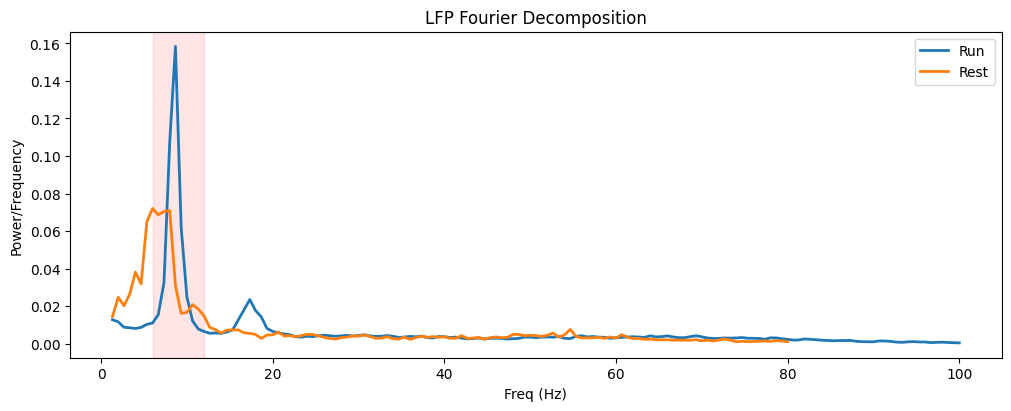

In [12]:
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(10, 4))
ax.plot(
    power_run[(power_run.index >= 1.0) & (power_run.index <= 100)],
    alpha=1,
    label="Run",
    linewidth=2,
)
ax.plot(
    power_rest[(power_rest.index >= 1.0) & (power_rest.index <= 80)],
    alpha=1,
    label="Rest",
    linewidth=2,
)
ax.axvspan(6, 12, color="red", alpha=0.1)
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Power/Frequency")
ax.set_title("LFP Fourier Decomposition")
ax.legend()

In [74]:
power_run[(power_run.index >= 1.0) & (power_run.index <= 100)]

,0
1.333333,0.012792
2.000000,0.011706
2.666667,0.008787
3.333333,0.008531
4.000000,0.008129
...,...
97.333333,0.000780
98.000000,0.000856
98.666667,0.000691
99.333333,0.000570


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def plot_cross_freq_coherence(freq_power, freqs=None, fs=1250, window_size=None, 
                             vmin=None, vmax=None, cmap='viridis'):
    """
    Plot cross-frequency coherence from a power spectrum vector with simulated coupling.
    
    Parameters:
    -----------
    freq_power : array-like
        Vector where values are power and indices correspond to frequencies
    freqs : array-like, optional
        Actual frequency values corresponding to indices. If None, uses indices
    fs : float, optional
        Sampling frequency (default: 1000 Hz)
    window_size : int, optional
        Size of the window for coherence calculation (default: auto-set)
    vmin : float, optional
        Minimum value for color scale (default: auto-set)
    vmax : float, optional
        Maximum value for color scale (default: auto-set)
    cmap : str, optional
        Colormap to use (default: 'viridis')
    
    Returns:
    -------
    fig : matplotlib.figure.Figure
        The generated figure object
    """
    
    # Convert input to numpy array and ensure 1D
    power_data = np.array(freq_power).flatten()
    if freqs is None:
        freqs = np.arange(len(power_data))
    else:
        freqs = np.array(freqs).flatten()
    
    if len(freqs) != len(power_data):
        raise ValueError(f"Length of freqs ({len(freqs)}) must match length of freq_power ({len(power_data)})")
    
    # Create two synthetic time series with some coupling
    t = np.linspace(0, 1, fs)
    signal1 = np.zeros(len(t))
    signal2 = np.zeros(len(t))
    np.random.seed(42)  # For reproducibility
    for i, freq in enumerate(freqs):
        phase_shift = np.random.uniform(0, np.pi)  # Random phase shift for coupling
        amplitude = np.sqrt(max(power_data[i], 0))
        signal1 += amplitude * np.sin(2 * np.pi * freq * t)
        signal2 += amplitude * np.sin(2 * np.pi * freq * t + phase_shift)  # Coupled signal
    
    # Auto-set window size
    if window_size is None:
        window_size = min(256, len(signal1) // 2)
    
    # Calculate coherence between the two signals
    f, Cxy = signal.coherence(signal1, signal2, fs=fs, nperseg=window_size)
    
    # Create coherence matrix
    n_freqs = len(freqs)
    coherence_matrix = np.zeros((n_freqs, n_freqs))
    for i in range(n_freqs):
        for j in range(n_freqs):
            idx_i = np.argmin(np.abs(f - freqs[i]))
            idx_j = np.argmin(np.abs(f - freqs[j]))
            coherence_matrix[i, j] = Cxy[idx_i] if idx_i == idx_j else np.mean(Cxy[[idx_i, idx_j]])
    
    # Auto-adjust vmin and vmax
    if vmin is None:
        vmin = np.min(coherence_matrix)
    if vmax is None:
        vmax = np.max(coherence_matrix)
    
    # Diagnostic output
    print(f"Coherence range: {vmin:.4f} to {vmax:.4f}")
    print(f"Frequency range: {freqs[0]:.2f} to {freqs[-1]:.2f} Hz")
    print(f"Window size: {window_size}")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(coherence_matrix, 
                   cmap=cmap,
                   vmin=vmin,
                   vmax=vmax,
                   origin='lower',
                   extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]],
                   aspect='auto')
    
    # Add colorbar
    plt.colorbar(im, label='Coherence')
    
    # Set labels
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title('Cross-Frequency Coherence')
    
    ax.grid(False)
    plt.tight_layout()
    return fig

# Assuming power_run is a pandas Series with frequency as index and power as values
frequencies = np.array(power_run[(power_run.index >= 1.0) & (power_run.index <= 100)].index.to_numpy())  # First column: frequency
power_spectrum = [num[0] for num in np.array(power_run[(power_run.index >= 1.0) & (power_run.index <= 100)].to_numpy())]  # Second column: power

# Plot
fig = plot_cross_freq_coherence(power_spectrum, freqs=frequencies, fs=1000)
plt.show()

NameError: name 'power_run' is not defined

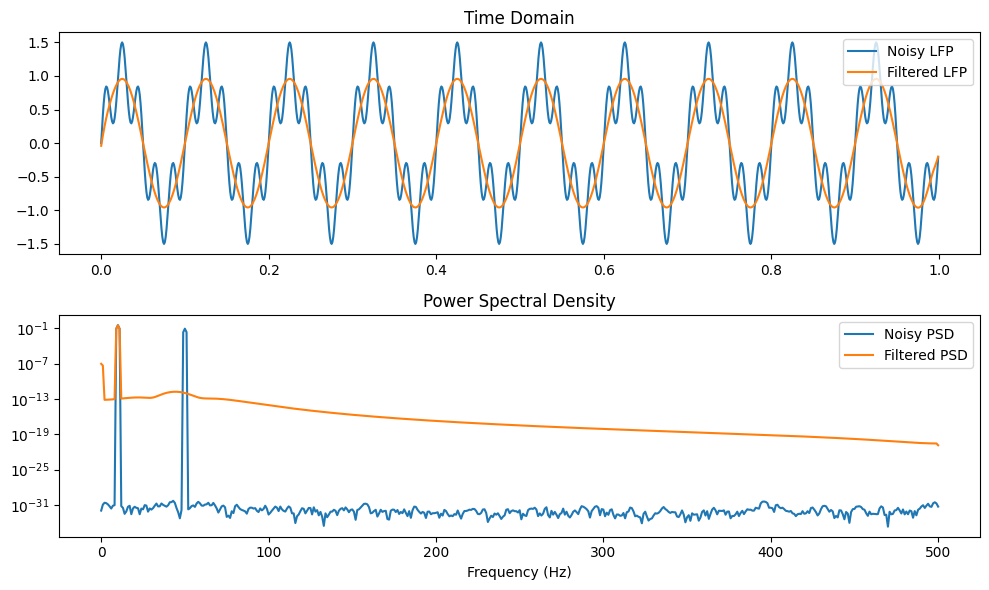

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Simulated LFP signal with 50 Hz noise
fs = 1000  # Sampling frequency in Hz
t = np.arange(0, 1, 1/fs)  # 1-second time vector
lfp_clean = np.sin(2 * np.pi * 10 * t)  # Simulated 10 Hz LFP signal
noise = 0.5 * np.sin(2 * np.pi * 50 * t)  # 50 Hz noise
lfp_signal = lfp_clean + noise  # Noisy signal

# Design the notch filter
f0 = 50  # Frequency to remove (Hz)
Q = 1   # Quality factor (higher = narrower bandwidth)
b, a = signal.iirnotch(f0 / (fs / 2), Q)  # Normalized frequency: f0 / (fs/2)

# Apply the filter
lfp_filtered = signal.filtfilt(b, a, lfp_signal)  # Zero-phase filtering




# Plot the results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, lfp_signal, label="Noisy LFP")
plt.plot(t, lfp_filtered, label="Filtered LFP")
plt.title("Time Domain")
plt.legend()

plt.subplot(2, 1, 2)
freq, psd_noisy = signal.welch(lfp_signal, fs, nperseg=1024)
freq, psd_filtered = signal.welch(lfp_filtered, fs, nperseg=1024)
plt.semilogy(freq, psd_noisy, label="Noisy PSD")
plt.semilogy(freq, psd_filtered, label="Filtered PSD")
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.tight_layout()
plt.show()